# Geolocation

- formulation of a solver.

- statistical simulations in order to determine sources of uncertainty

---

# 1 - Formulation

<img src='schematic.jpeg' alt='Drawing' align='right' style='width: 300px;'/>

We want to find the float horizontal position $\underline{x}=(x,y)$ of an underwater float 
given a number of **known variables**:
- $\underline{x}_s^i$ : source surface float horizontal position
- $t_e^i$ : time of emission for source $i$
- $\tilde{t}_r^i$ : time of reception of the signal emitted by source $i$ by the underwater float
- $\epsilon_i$ : signal detection, $\epsilon_i=1$ (detection) or $1$ (no detection)
- $z$ : underwater float depth(perfect knowledge), not used for now

'Perfect' knowledge is assumed for known variables wich amounts to say potential errors on there
estimates may be neglected.

**Unknown variables** are:
- $\underline{x}=(x,y)$ : underwater float position
- $\delta t$ : underwater float clock offset, $\delta t = \tilde{t}_r^i - t_r^i$, where 
$t_r^i$ is the true time of reception
- $\delta \underline{x}^i$ : vector difference between source $i$ transducer position and surface float position, $\delta \underline{x}^i = \underline{x}_t^i - \underline{x}_s^i$
- $\delta c (\underline{x},\underline{x}_t^i)$ : difference between equivalent celerity defined as 
$c(\underline{x},\underline{x}_t^i) = ||\underline{x} - \underline{x}_t^i ||/(t_r^i - t_e^i)$ and its background (a priori) estimate $c_b$, $\delta c (\underline{x},\underline{x}_t^i) = c(\underline{x},\underline{x}_t^i) - c_b$.

A priori standard deviations for $\underline{x}$, $\delta t$, $\delta \underline{x}^i$, $\delta c (\underline{x},\underline{x}_t^i)$ are
assumed to be known and given by: $e_x$, $e_{\delta t}$, $e_{\delta x}$, $e_{\delta c}$.

Background (a priori) estimates for $\underline{x}$, $\delta t$, $\delta \underline{x}^i$, $\delta c (\underline{x},\underline{x}_t^i)$ may eventually be provided. We assume all are 0 for now except
for the float position $\underline{x}_b=(x=1km, y=0km)$.


We impose **hard contraints** for each source-float acoustic travel:

$$
\begin{align*}
||\underline{x} - \underline{x}_s^i || = \big (c_b + \delta c(\underline{x},\underline{x}_t^i) \big ) \times (\tilde{t}_r^i + \delta t - t_e^i),
\end{align*}
$$

The estimate of the underwater float position $\underline{\hat{x}}$ minimizes:

$$
\begin{align*}
J(\mathbf{x}, \delta t, \delta c (\underline{x},\underline{x}_t^i)) = 
||\underline{x} - \underline{x}_b||^2 /e_x^2
+ \delta t^2 / e_{\delta t}^2 
+ \sum_i \epsilon_i \times (\delta c (\underline{x},\underline{x}_t^i)^2 / e_c^2 )
\end{align*}
$$

subject to the hard constraints listed above.

The hard constraint may used to estimate $\delta c$ and plug it into the functional J:
$$
\begin{align*}
J(\mathbf{x}, \delta t) = 
||\underline{x} - \underline{x}_b||^2 /e_x^2
+ \delta t^2 / e_{\delta t}^2 
+ \sum_i \epsilon_i \times \Big \{ \frac{\big [||\underline{x} - \underline{x}_s^i ||/(\tilde{t}_r^i 
+ \delta t - t_e^i) - c_b \big ]^2} {e_c^2} \Big \}
\end{align*}
$$

We assume $\epsilon_i=1$ in all examples below for simplicity.

We have assumed simultaneous (working assumption) emission of sources.
The underwater float velocity may be added as an extra variable (future addition).

In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2

# import libraries
import numpy as np
import matplotlib.pyplot as plt

from clib.geolocation import *


---
# 2 - Create an ensemble of sources

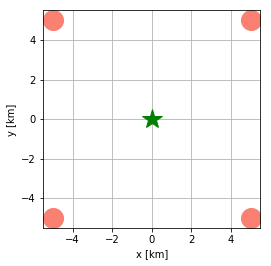

In [57]:
### create an ensemble of sources
dx=10. *1.e3 # in meters
sources=[]
sources.append(source(-dx*.5,-dx*.5))
sources.append(source(dx*.5,-dx*.5))
sources.append(source(dx*.5,dx*.5))
sources.append(source(-dx*.5,dx*.5))
Ns = len(sources)

### init a receiver
r=receiver(0. *1.e3, 0. *1.e3)

### plot
plt.figure()
ax=plt.subplot(111)
[s.plot() for s in sources]
r.plot()
ax.grid()
ax.set_aspect('equal')
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.show()

In [3]:
for i, s in enumerate(sources):
    print('Distance source %d - float = %.2f km' %(i, dist(s,r)/1.e3))
    print('    horizontal offset for a sound celerity difference of %.1f m/s = %.2f m' %(10., dist(s,r)*10./1500.))

Distance source 0 - float = 7.07 km
    horizontal offset for a sound celerity difference of 10.0 m/s = 47.14 m
Distance source 1 - float = 7.07 km
    horizontal offset for a sound celerity difference of 10.0 m/s = 47.14 m
Distance source 2 - float = 7.07 km
    horizontal offset for a sound celerity difference of 10.0 m/s = 47.14 m
Distance source 3 - float = 7.07 km
    horizontal offset for a sound celerity difference of 10.0 m/s = 47.14 m


**- A priori uncertainties and estimates are :**

In [4]:
# a priori uncertainties : 
print("e_c  = %.1f m/s  (celerity)" %s.e_c)
print("e_dt = %.1f s  (clock drift)" %r.e_dt)
print("e_x  = %.1f m  (underwater float position)" %r.e_x)
#print("e_dx = %.1f m  (dx between transducer and surface float)" %s.e_dx)

e_c  = 10.0 m/s  (celerity)
e_dt = 1.0 s  (clock drift)
e_x  = 10000.0 m  (underwater float position)


In [5]:
# a priori estimates :
x0 = np.zeros((3))
# a priori position :
x0[0] = 1.e3
x0[1] = 0.e3 

---
# 3 - Statistical simulations for 1 receiver position

For each source-receiver acoustic path, a random value of c is drawn around **c_b = 1500m/s**.
The standard deviation of the celerity is **e_c = 10 m/s**.

**- The true underwater float position and clock offset are:**

In [6]:
print('x = %.1f m \ny = %.1f m \ndt = %.1e s' %(r.x, r.y, r.dt))

x = 0.0 m 
y = 0.0 m 
dt = 7.3e-01 s


**- Unchanged variables during simulations are : **

In [7]:
print("s.x_t :", [s.x_t for s in sources])
print("s.y_t :", [s.y_t for s in sources])
print("s.dx  :", [s.dx for s in sources])
print("s.dy  :", [s.dy for s in sources])
print("r.dt  :", r.dt)

s.x_t : [array([-5004.49276212]), array([5004.2711911]), array([5017.7911043]), array([-5003.96771693])]
s.y_t : [array([-5001.75552498]), array([-4999.41039786]), array([4998.64773451]), array([4994.64757158])]
s.dx  : [array([-4.49276212]), array([4.2711911]), array([17.7911043]), array([-3.96771693])]
s.dy  : [array([-1.75552498]), array([0.58960214]), array([-1.35226549]), array([-5.35242842])]
r.dt  : [0.73465866]


**- Simulations : only celerity between receiver and each source is changing** 

In [8]:
Nmc = 1000
x=np.zeros(Nmc)
y=np.zeros(Nmc)
dt=np.zeros(Nmc)

for i in range(Nmc):
    [s.draw_celerity(s.e_c) for s in sources]
    x[i], y[i], dt[i], success, message, res = geolocalize_xydt(r, sources, disp=False)

**- Plot results** 

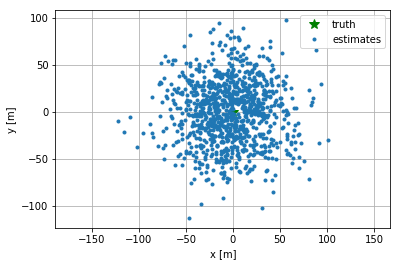

In [9]:
plt.figure()
ax=plt.subplot(111)
ax.plot(r.x,r.y,'*', color='green', markersize=10, label='truth')
ax.plot(x,y,'.', label='estimates')
ax.axis('equal')
ax.grid()
ax.legend()
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.show()

**- RMS and bias calculations on position **

In [10]:
# RMS 
d_rms = np.sqrt( np.mean( (x - r.x)**2  + (y - r.y)**2 ) )
print('RMS : %.2fm' %d_rms)

# biais on the receiver position
biais_x = x.mean()-r.x
biais_y = y.mean()-r.y
biais = np.sqrt(biais_x**2 + biais_y**2)
print('X bias : %.2fm' %biais_x)
print('Y bias : %.2fm' %biais_y)
print('Bias on position : %.2fm' %biais)

RMS : 47.20m
X bias : -3.50m
Y bias : -0.13m
Bias on position : 3.50m


---
# 4 - Error map 

**- Function "simu" : simulations for one receiver position ; returns rms and bias.  **

In [11]:
def simu (r, sources, Nmc, var) : 
    x=np.zeros(Nmc)
    y=np.zeros(Nmc)
    dt=np.zeros(Nmc)
    for i in range(Nmc):
        
        if var == 'celerity' : 
            [s.draw_celerity(s.e_c) for s in sources]
        if var == 'dxdy' : 
            [s.draw_dxdy(10.) for s in sources]
        if var == 'clock' : 
            r.draw_clock_drift()
            #dt_truth[i] = r.dt    
        x[i], y[i], dt[i], success, message, res = geolocalize_xydt(r, sources, disp=False)

    # rms error on the receiver position
    d_rms = np.sqrt( np.mean( (x - r.x)**2  + (y - r.y)**2 ) )
    # biais on the receiver position
    biais_x = x.mean()-r.x
    biais_y = y.mean()-r.y
    biais = np.sqrt(biais_x**2 + biais_y**2)
    return (d_rms, biais)

**- Creation of a grid : **

In [12]:
Lx = 20.* 1.e3
Ly = Lx 
xt = np.linspace(-Lx/2.,Lx/2.,20)   # 20 values on 20km : resolution of 1km 
yt = np.linspace(-Ly/2.,Ly/2.,20)
Xt, Yt = np.meshgrid(xt,yt)

**- Calculations for each receiver position :** 

In [13]:
### number of simulations 
Nmc = 100
var = 'celerity'

In [ ]:
### map calculations
RMS = np.zeros((len(xt),len(yt)))
Biais = np.zeros((len(xt),len(yt)))
dt = r.dt
for i in range (len(xt)) :
    print('i = %d/%d' %(i+1,len(xt)))
    for j in range (len(yt)):
        # init a receiver
        r = receiver(xt[i], yt[j])
        r.dt = dt # unchanged variable during simulations 
        # simulations 
        d_rms, biais = simu (r, sources, Nmc, var = var) 
        RMS[i,j]   = d_rms
        Biais[i,j] = biais

### saving        
np.save('RMS_20_20', RMS)
np.save('Biais_20_20', Biais)

In [14]:
RMS1 = np.load('NPY/RMS_20_20.npy')
Biais1 = np.load('NPY/Biais_20_20.npy')

**- Plots : error map + bias map**

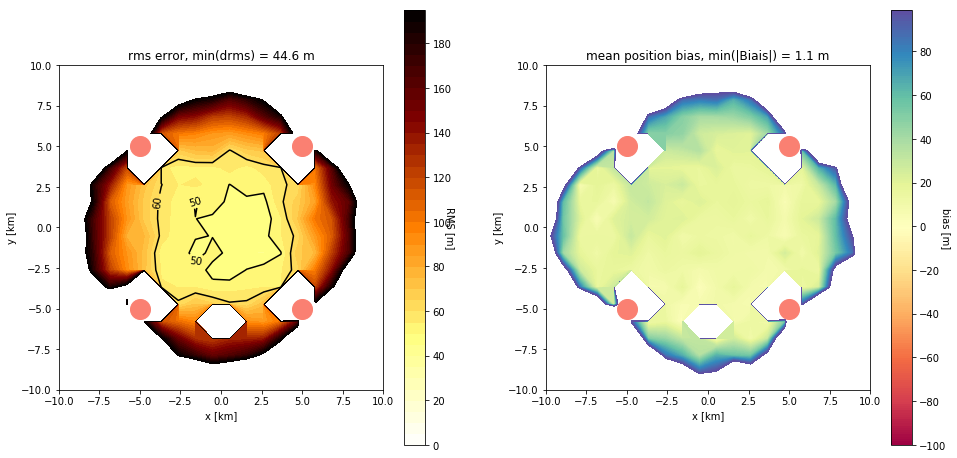

In [15]:
plt.figure(figsize=(16,8))

## error
ax=plt.subplot(121)
cmap = plt.get_cmap('afmhot_r')
lvls=np.arange(0.,2.e2,5.)
plt.contourf(Xt/1.e3,Yt/1.e3,RMS1,lvls, cmap=cmap)  #,lvls
cbar = plt.colorbar()
cbar.ax.set_ylabel('RMS [m]', rotation=270)

CS = plt.contour(Xt/1.e3,Yt/1.e3,RMS1,[50,60],colors='k')
plt.clabel(CS, [50,60],  # label every second level
           inline=1,
           fmt='%1.0f',
           fontsize=10)
[s.plot() for s in sources]
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('rms error, min(drms) = %.1f m' % RMS1.min())
ax.set_aspect('equal')

## bias
ax=plt.subplot(122)
cmap = plt.get_cmap('Spectral')
lvls=np.arange(-10.e1,10.e1,1.e0)
plt.contourf(Xt/1.e3,Yt/1.e3, Biais1,lvls,cmap=cmap)
cbar = plt.colorbar()
cbar.ax.set_ylabel('bias [m]', rotation=270)
[s.plot() for s in sources]
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('mean position bias, min(|Biais|) = %.1f m' % np.abs(Biais1).min())
ax.set_aspect('equal')
plt.show()
plt.show()

**- Zoom on 1km around a source** 

In [16]:
Lx_z = 2.* 1.e3
Ly_z = Lx_z 
xt_z = np.linspace(5.*1.e3 - Lx_z/2., 5.*1.e3 + Lx_z/2., 20)   # 20 values on 2km : resolution of 100m 
yt_z = np.linspace(5.*1.e3 - Lx_z/2., 5.*1.e3 + Lx_z/2., 20)
Xt_z, Yt_z = np.meshgrid(xt_z,yt_z)

In [ ]:
RMS_zoom = np.zeros((len(xt_z),len(yt_z)))
Biais_zoom = np.zeros((len(xt_z),len(yt_z)))
dt = r.dt
for i in range (len(xt_z)) :
    print('i = %d/%d' %(i+1,len(xt_z)))
    for j in range (len(yt_z)):
        r = receiver(xt_z[i], yt_z[j])
        r.dt = dt 
        d_rms, biais = simu (r, sources, Nmc, var = var) 
        RMS_zoom[i,j]   = d_rms
        Biais_zoom[i,j] = biais

### saving        
np.save('RMS_zoom_source', RMS_zoom)
np.save('Biais_zoom_source', Biais_zoom)

In [17]:
RMS_zoom = np.load('NPY/RMS_zoom_source.npy')
Biais_zoom = np.load('NPY/Biais_zoom_source.npy')

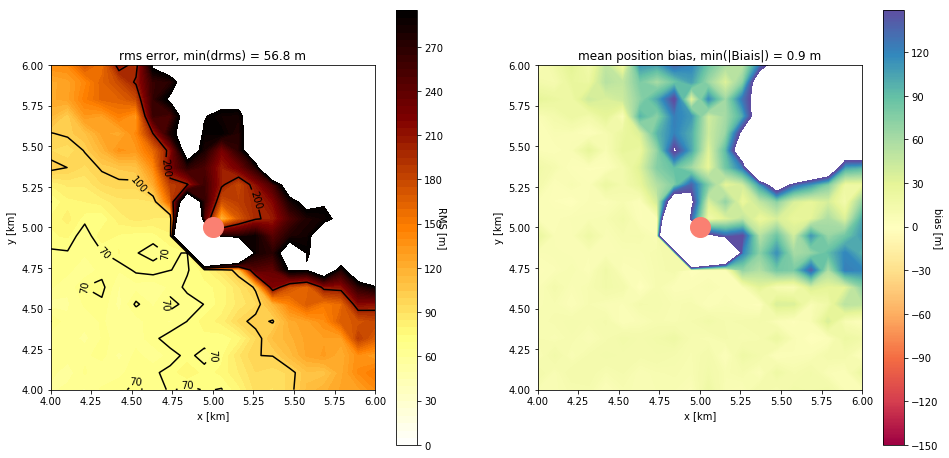

In [18]:
plt.figure(figsize=(16,8))

## error
ax=plt.subplot(121)
cmap = plt.get_cmap('afmhot_r')
lvls=np.arange(0.,3.e2,5.)
plt.contourf(Xt_z/1.e3,Yt_z/1.e3,RMS_zoom,lvls, cmap=cmap)  #,lvls
cbar = plt.colorbar()
cbar.ax.set_ylabel('RMS [m]', rotation=270)
CS = plt.contour(Xt_z/1.e3,Yt_z/1.e3,RMS_zoom,[70,100,200],colors='k')
plt.clabel(CS, [70,100,200], inline=1, fmt='%1.0f', fontsize=10)
sources[2].plot()
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('rms error, min(drms) = %.1f m' % RMS_zoom.min())
ax.set_aspect('equal')

## bias
ax=plt.subplot(122)
cmap = plt.get_cmap('Spectral')
lvls=np.arange(-15.e1,15.e1,1.e0)
plt.contourf(Xt_z/1.e3,Yt_z/1.e3, Biais_zoom,lvls,cmap=cmap)
cbar = plt.colorbar()
cbar.ax.set_ylabel('bias [m]', rotation=270)
sources[2].plot()
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('mean position bias, min(|Biais|) = %.1f m' % np.abs(Biais_zoom).min())
ax.set_aspect('equal')
plt.show()

---
# 5 - Transects

Calculations to create a map take a long time : it seems better to work with only one transect. 

**- Calculation and plot functions for transects : **

In [53]:
def transect (sources, X, Y, Nmc, var) :
    RMS_t = np.zeros((len(X)))
    Biais_t = np.zeros((len(X)))
    for i in range (len(X)) :
        # init a receiver
        r = receiver(X[i], Y)
        r.dt = 1. # unchanged variable during simulations 
        #
        d_rms, biais = simu (r, sources, Nmc, var = var) 
        RMS_t[i]   = d_rms
        Biais_t[i] = biais
    return RMS_t, Biais_t


def plot_transect (sources, X, Y, RMS_t, Biais_t):
    print('min (rms) = %.1f m' %np.min(RMS_t))
    print('min (bias) = %.1f m' %np.min(Biais_t))
    plt.figure(figsize=(17,4))
    # plot sources 
    ax=plt.subplot(131)
    [s.plot() for s in sources]
    plt.title ('sources and transect')
    plt.xlabel('x [km]')
    plt.ylabel('y [km]')
    ax.grid()
    #ax.set_xlim([np.min(X)/1000.,np.max(X)/1000.])
    ax.set_ylim([-abs(sources[0].y_s)/1000. - 5., abs(sources[0].y_s)/1000. + 5.])
    ax.set_aspect('equal')
    plt.plot([np.min(X)/1000.,np.max(X)/1000.],[Y/1000.,Y/1000.],'.-b')

    ## plot rms result
    ax2 = plt.subplot(132)
    ax2.grid()
    plt.plot(X/1.e3, RMS_t, '.') 
    plt.xlabel('x [km]')
    plt.ylabel('RMS [m]')
    plt.title('RMS error along the transect Y=%.dkm' %int(Y/1000.))
    
    ## plot bias
    ax3  = plt.subplot(133)
    ax3.grid()
    plt.plot(X/1.e3, Biais_t, '.')
    plt.xlabel('x [km]')
    plt.ylabel('Bias [m]')
    plt.title('Bias along the transect Y=%.dkm' %int(Y/1000.))
    
    plt.show()

**- Creation of a transect : **

In [20]:
L = 40.* 1.e3
X = np.linspace(-L/2.,L/2.,200)  # resolution : 200m
Y = 0. 

**A - Distance between sources : 10km, with Y=0 km **

In [21]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t, Biais_t = transect (sources, X, Y, Nmc, var)

min (rms) = 42.3 m
min (bias) = 0.3 m


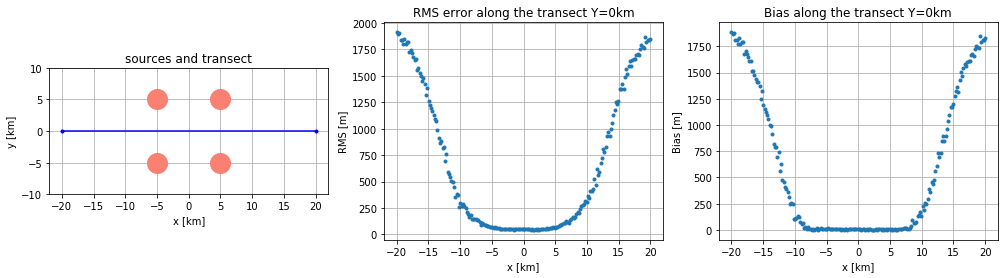

In [58]:
plot_transect(sources, X, Y, RMS_t, Biais_t)

**B - Same distance, with Y=5 km **

In [60]:
Y = 5000.

In [36]:
RMS_t5, Biais_t5 = transect (sources, X, Y, Nmc, var)

min (rms) = 61.4 m
min (bias) = 4.2 m


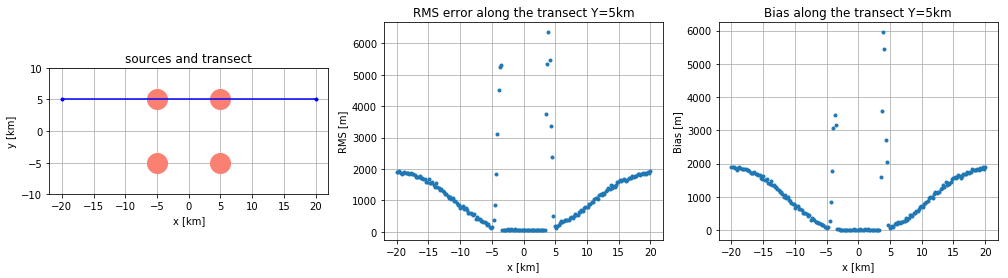

In [61]:
plot_transect(sources, X, Y, RMS_t5, Biais_t5)

**C - Distance between sources : 20km **

In [62]:
Y = 0.

In [63]:
dx=20. *1.e3 # in meters
sources=[]
sources.append(source(-dx*.5,-dx*.5))
sources.append(source(dx*.5,-dx*.5))
sources.append(source(dx*.5,dx*.5))
sources.append(source(-dx*.5,dx*.5))
Ns = len(sources)

In [40]:
RMS_t_20km, Biais_t_20km = transect (sources, X, Y, Nmc, var)

min (rms) = 84.3 m
min (bias) = 2.2 m


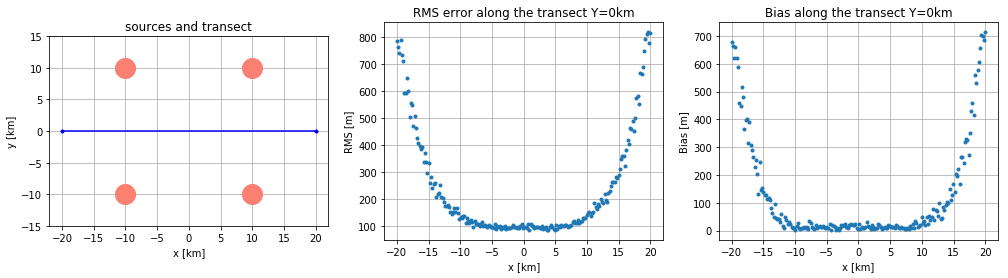

In [64]:
plot_transect(sources, X, Y, RMS_t_20km, Biais_t_20km)

**D - With 5 sources (one on the center) **

In [65]:
# 5th source added
sources.append(source(0.,0.))
Ns = len(sources)

In [66]:
RMS_t20_5sources, Biais_t20_5sources = transect (sources, X, Y, Nmc, var)

min (rms) = 63.8 m
min (bias) = 0.9 m


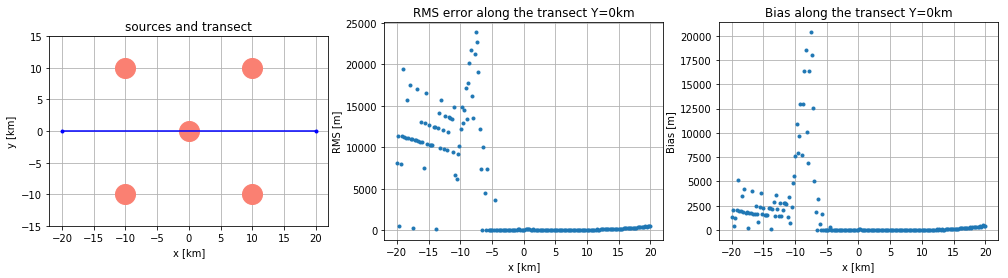

In [67]:
plot_transect(sources, X, Y, RMS_t20_5sources, Biais_t20_5sources)

In [ ]:
### tableau des minimums de RMS et biais suivant les config ??